In [1032]:
import numpy as np
np.set_printoptions(suppress=True)

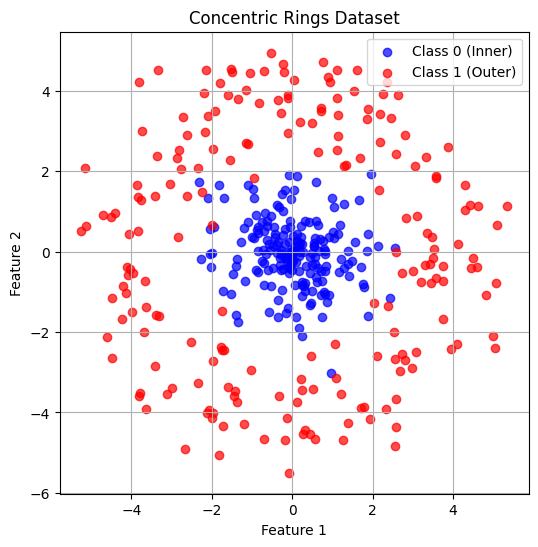

In [1033]:
#Binary classification
import matplotlib.pyplot as plt

# random dataset

NUM_SAMPLES_PER_CLASS = 200
INNER_RADIUS = 2
OUTER_RADIUS = 5
NOISE_STD_DEV = 0.5

theta_inner = 2 * np.pi * np.random.rand(NUM_SAMPLES_PER_CLASS)

radius_inner = INNER_RADIUS * np.random.rand(NUM_SAMPLES_PER_CLASS) + np.random.normal(0, NOISE_STD_DEV, NUM_SAMPLES_PER_CLASS)
x0 = radius_inner * np.cos(theta_inner)
y0 = radius_inner * np.sin(theta_inner)
class0_points = np.vstack([x0, y0]).T
class0_labels = np.zeros(NUM_SAMPLES_PER_CLASS)

theta_outer = 2 * np.pi * np.random.rand(NUM_SAMPLES_PER_CLASS)

radius_outer = np.random.uniform(INNER_RADIUS + 1, OUTER_RADIUS, NUM_SAMPLES_PER_CLASS) + np.random.normal(0, NOISE_STD_DEV, NUM_SAMPLES_PER_CLASS)
x1 = radius_outer * np.cos(theta_outer)
y1 = radius_outer * np.sin(theta_outer)
class1_points = np.vstack([x1, y1]).T
class1_labels = np.ones(NUM_SAMPLES_PER_CLASS)


X = np.vstack([class0_points, class1_points])
y = np.hstack([class0_labels, class1_labels])
y = y.reshape(-1, 1) # stupid broadcasting bug that i spent an hour on -.-


plt.figure(figsize=(8, 6))

plt.scatter(class0_points[:, 0], class0_points[:, 1], c='blue', label='Class 0 (Inner)', alpha=0.7)

plt.scatter(class1_points[:, 0], class1_points[:, 1], c='red', label='Class 1 (Outer)', alpha=0.7)
plt.title('Concentric Rings Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [1034]:
# Mnist dataset
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype('float64') / 255.0).reshape(-1,28*28)
X_test = (X_test.astype('float64') / 255.0).reshape(-1,28*28)

X = X_train[:1000,:]
y = y_train.reshape(60000, -1)[:1000,:]

In [1035]:
X.shape, y.shape

((1000, 784), (1000, 1))

In [1036]:
def one_hot_encoding(vector):
    vector = np.array(vector).astype(int)
    if vector.ndim == 1:
        return vector
    size=len(vector)
    num_classes = len(np.unique(vector))

    encoded_matrix = np.zeros((size, num_classes))
    encoded_matrix[np.arange(size), vector] = 1
    return encoded_matrix

In [1037]:
def initialize_weights_and_biases(m_inputs, layer_sizes:list):
    weights = {}
    biases = {}

    layers = [m_inputs] + layer_sizes

    for i in range(len(layers)-1):
        weights["W" + str(i+1)] = np.random.randn(layers[i], layers[i+1])# * 0.01 left out due to vanishing gradients
        biases["b" + str(i+1)] = np.zeros((1, layers[i+1]))

    # print(f"Successfully initialized weights and biases for {len(layer_sizes)} layers")
    return weights, biases


In [1038]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0,z)

def softmax(z):
    exponent_values = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exponent_values / np.sum(exponent_values, axis=1, keepdims=True)

In [1039]:
def forward(A, weights, biases, activation_function):
    Z_dict = {}
    A_dict = {}
    A_dict["A0"] = A
    l_dict = {}

    if activation_function == 'relu':
        activation_function = relu
    else:
        activation_function = sigmoid


    for i in range(len(weights)-1): #loop through hidden layers
        a_prev = A
        Z = np.dot(a_prev, weights["W" + str(i+1)]) + biases["b" + str(i+1)]
        Z_dict["Z" + str(i+1)] = Z
        A = activation_function(Z)
        A_dict["A" + str(i+1)] = A
        l_dict['layer' + str(i+1)] = activation_function.__name__

    last_index = len(weights)

    if weights[list(weights.keys())[-1]].shape[1] == 1:
        output_activation = sigmoid
    else:
        output_activation = softmax

    a_prev = A
    Z = np.dot(a_prev, weights["W" + str(last_index)]) + biases["b" + str(last_index)]
    Z_dict["Z" + str(last_index)] = Z
    A = output_activation(Z)
    A_dict["A" + str(last_index)] = A
    l_dict['layer' + str(last_index)] = output_activation.__name__


    cache = {"Z":Z_dict,
             "A":A_dict,
             'layer_activations':l_dict}

    # print("Successfully computed a forward pass")
    return cache

In [1040]:
def calculate_loss(y_pred, y_true, loss='binary_cross_entropy'):
    epsilon = 1e-8

    if loss == 'cross_entropy':
        return - np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
    else:
        return - np.mean(y_true * np.log(y_pred + epsilon) + (1-y_true)*np.log(1-y_pred + epsilon)) # added 1e-8 to avoid log(0)

In [1041]:
# # test run
# W, b =initialize_weights_and_biases(2, [4, 4, 1])
# cache = forward(X, W, b)
# prediction = cache['A'][list(cache['A'].keys())[-1]]

# calculate_loss(prediction, y)

In [1042]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu_derivative(z):
    return (z > 0).astype(float)

In [1043]:
def backpropagation(X, y, weights, biases, cache):

    activation_derivative = sigmoid_derivative

    A_cache = cache['A']
    Z_cache = cache['Z']
    L_cache = cache['layer_activations']

    Z_gradients = {}
    A_gradients = {}
    W_gradients = {}
    b_gradients = {}

    m = X.shape[0]

    for i in reversed(range(len(weights))):
        if L_cache['layer' + str(i+1)] == 'relu':
            activation_derivative = relu_derivative
        if L_cache['layer' + str(i+1)] == 'sigmoid':
            activation_derivative = sigmoid_derivative


        if i+1 == len(weights): #special case for first dZ
            dZ = A_cache["A" + str(i+1)] - y
            Z_gradients["dZ" + str(i+1)] = dZ
            W_gradients["dW" + str(i+1)] = np.dot(A_cache["A" + str(i)].T,dZ) / m
            b_gradients["db" + str(i+1)] = np.sum(dZ, axis=0, keepdims=True) / m
        else:
            dZ = np.dot(Z_gradients["dZ" + str(i+2)], weights["W" + str(i+2)].T ) * activation_derivative(Z_cache["Z" + str(i+1)])
            Z_gradients["dZ" + str(i+1)] = dZ
            W_gradients["dW" + str(i+1)] = np.dot(A_cache["A" + str(i)].T,dZ) / m
            b_gradients["db" + str(i+1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # print(f"Layer {i+1} dW magnitude: {np.linalg.norm(W_gradients['dW' + str(i+1)])}")
        # print(f"Layer {i+1} db magnitude: {np.linalg.norm(b_gradients['db' + str(i+1)])}")

    grads = {"dW" : W_gradients,
             "db" : b_gradients}

    return grads

In [1044]:
def update_params(grads, weights, biases, learning_rate:float):

    dw = grads['dW']
    db = grads['db']

    for i in range(len(weights)):
        weights["W" + str(i+1)] = weights["W" + str(i+1)] - learning_rate * dw["dW" + str(i+1)]
        biases["b" + str(i+1)] = biases["b" + str(i+1)] - learning_rate * db["db" + str(i+1)]

    # print("Successfully updated params")
    return weights, biases

In [1045]:
def predict(X, weights, biases):
    cache = forward(X, weights, biases, activation_function='relu')
    prediction = cache['A'][list(cache['A'].keys())[-1]]
    return prediction

In [1046]:
weights, biases = initialize_weights_and_biases(m_inputs=784, layer_sizes=[2,10])

In [1047]:
# full network

epochs = 500
learning_rate = 0.00001

# if classification is multiclass then we want to onehot encode y
if len(np.unique(y)) > 2:
    y = one_hot_encoding(y)
    classification_type = 'multi'
else:
    classification_type = 'single'


total = len(y)

for i in range(epochs):
    cache = forward(X, weights, biases, activation_function='relu')
    prediction = cache['A'][list(cache['A'].keys())[-1]]
    grads = backpropagation(X, y, weights, biases, cache)

    if i % 100 == 0:
        if classification_type == 'single':
            accuracy = np.sum((prediction > 0.5).astype(int) == y) / total
        else:
            predicted_class = np.argmax(prediction, axis=1)
            true_class = np.argmax(y, axis=1)
            accuracy = np.mean(predicted_class == true_class)
        print(f"epoch: {(i//100)+1}, loss= {calculate_loss(prediction, y)}, accuracy= {accuracy}")

    update_params(grads, weights, biases, learning_rate)

epoch: 1, loss= 8.132783044292253, accuracy= 0.246
epoch: 2, loss= 8.147544236971981, accuracy= 0.0
epoch: 3, loss= 8.16322203893591, accuracy= 0.0
epoch: 4, loss= 8.179750308555795, accuracy= 0.0
epoch: 5, loss= 8.197110728519307, accuracy= 0.0


In [1048]:
#visualize mnist

def plot_predictions(X, y_true, y_pred, num_images=10):
    """
    X is of shape (m, 28*28) where m is the # samples

    """

In [1049]:
# import numpy as np
# import matplotlib.pyplot as plt

# h = 0.05
# x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
# y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# grid_points = np.c_[xx.ravel(), yy.ravel()]

# preds = predict(grid_points, weights, biases)

# Z = (preds > 0.5).astype(int)
# Z = Z.reshape(xx.shape)


# plt.figure(figsize=(8,6))
# plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# plt.scatter(class0_points[:, 0], class0_points[:, 1], c='blue', label='Class 0 (Inner)', alpha=0.7)
# plt.scatter(class1_points[:, 0], class1_points[:, 1], c='red', label='Class 1 (Outer)', alpha=0.7)

# plt.title("Decision Boundary")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.legend()
# plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
